## Project 04
### James Grasell
### April 26, 2021

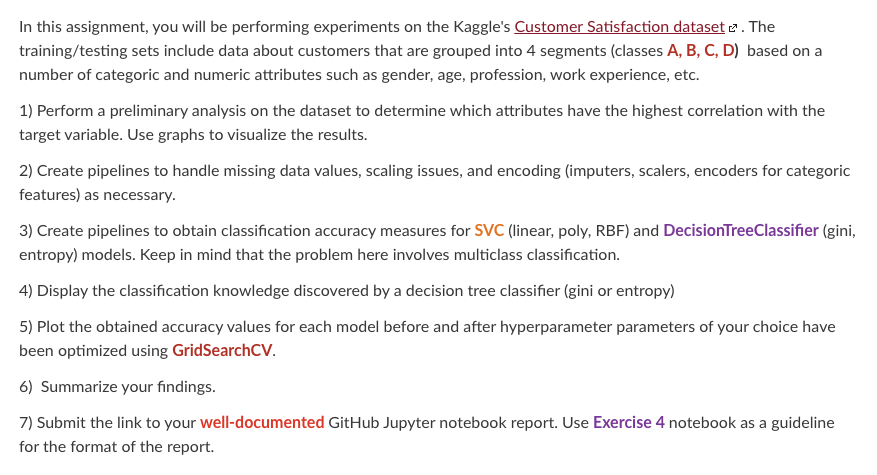

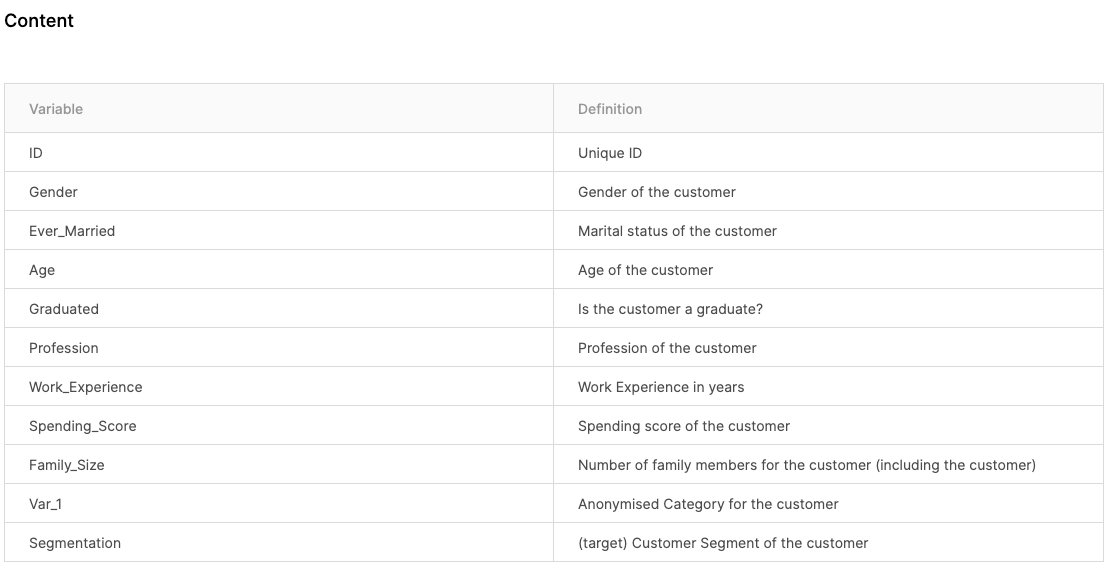

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [34]:
# Read in the Customer Segmentation data from github
train_url = 'https://raw.githubusercontent.com/jimgrasell/AML/master/Project04/Data/Train.csv'
test_url = 'https://raw.githubusercontent.com/jimgrasell/AML/master/Project04/Data/Test.csv'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

# Split target from features and drop unnecessary columns
X_train = train_df.drop(['ID','Segmentation'], axis=1)
y_train = train_df['Segmentation']
X_test = test_df.drop(['ID','Segmentation'], axis=1)
y_test = test_df['Segmentation']

# Examine the training data
X_train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


# Correlations
Calculating correlations between the numeric features and the target (Segmentation) is problematic since it can not be assumed that the target can be recoded as a continuous or ordinal numeric data type. For the purpose of this assignment I will assume Segmentation can be recoded into an ordinal variable (I don't agree with this assumption). This is the only way to generate the correlation heatmap.

In [35]:
# Create an ordinal variable for Segmentation
def recode(x):
    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    elif x == 'C':
        return 3
    elif x == 'D':
        return 4

train_df['Segmentation_ordinal'] = train_df['Segmentation'].apply(recode)

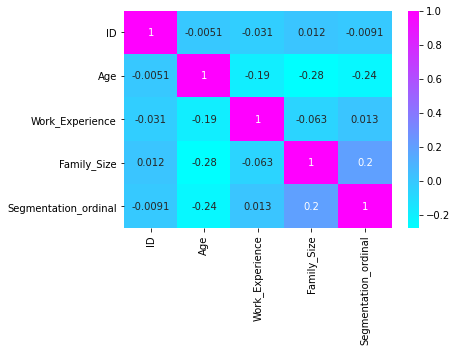

In [37]:
import pandas as pd
import seaborn as sns

g = sns.heatmap(train_df.corr(),
                annot=True, 
                cmap = "cool")

# The correlations indicate that ID (as expected) and Work_Experience are not correlated with Segmentation and can be excluded from the modeling.

In [17]:
import matplotlib.pyplot as plt

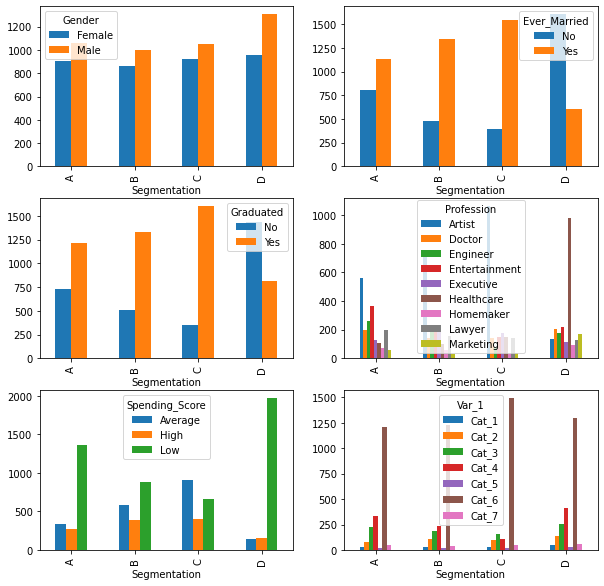

In [25]:
figure, axes = plt.subplots(3,2)

ct1 = pd.crosstab(y_train[:], X_train['Gender'])
ct1.plot.bar(ax = axes[0,0], figsize=(10,10))

ct2 = pd.crosstab(y_train[:], X_train['Ever_Married'])
ct2.plot.bar(ax = axes[0,1], figsize=(10,10))

ct3 = pd.crosstab(y_train[:], X_train['Graduated'])
ct3.plot.bar(ax = axes[1,0], figsize=(10,10))

ct4 = pd.crosstab(y_train[:], X_train['Profession'])
ct4.plot.bar(ax = axes[1,1], figsize=(10,10))

ct5 = pd.crosstab(y_train[:], X_train['Spending_Score'])
ct5.plot.bar(ax = axes[2,0], figsize=(10,10))

ct6 = pd.crosstab(y_train[:], X_train['Var_1'])
ct6.plot.bar(ax = axes[2,1], figsize=(10,10))

Based on the bar-plots (above) the categorical variables Ever_Married, Graduated, Profession, and Spending_Score should be useful in predicting Segmentation. Gender and Var_1 do not appear to be as useful in predicting Segmentation.

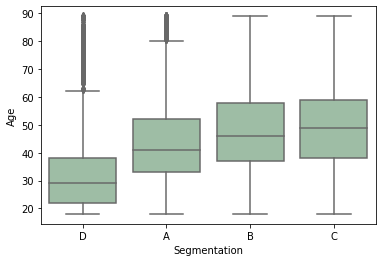

In [27]:
import seaborn as sns
ax = sns.boxplot(x='Segmentation', y='Age', data=train_df, color='#99c2a2')
plt.show()

Age should be useful in predicting Segmentation

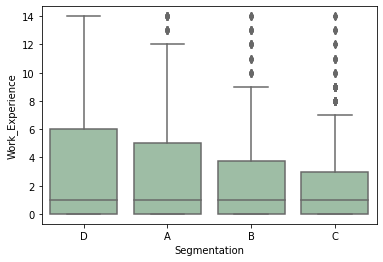

In [28]:
ax = sns.boxplot(x='Segmentation', y='Work_Experience', data=train_df, color='#99c2a2')
plt.show()

Work_Experience does not seem to be useful in predicting Segmentation

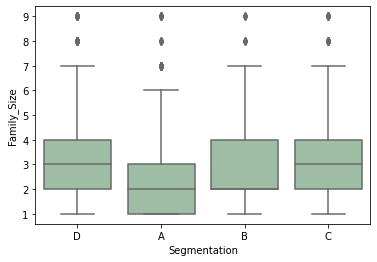

In [29]:
ax = sns.boxplot(x='Segmentation', y='Family_Size', data=train_df, color='#99c2a2')
plt.show()

Family_Size should be helpful in predicting Segmentation

### Summary of Important Features.
The plots identify that the following features should be useful in predicting Segmentation:


*   Ever_Married
*   Graduated
*   Profession
*   Spending_Score
*   Age
*   Family_Size




In [12]:
# Missing data in the training file
X_train.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [15]:
# Missing data in the test file
X_test.isnull().sum()

Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

In [40]:
cat_cols = ['Ever_Married', 'Graduated', 'Profession', 'Spending_Score']

cat_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder())
])

num_cols = ['Age', 'Family_Size']

num_transformer = Pipeline(steps=[
      ('imputer', KNNImputer(n_neighbors=5)),
      ('scaler', StandardScaler())

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

num_folds = 10

########## A decicion tree with gini
gini_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='gini'))])

gini_dt_score = cross_val_score(gini_dt_clf, X_train, y_train, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with entropy
entropy_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(criterion='entropy'))])

entropy_dt_score = cross_val_score(entropy_dt_clf, X_train, y_train, cv=num_folds, scoring="accuracy").mean()


########## An RBF kernel classifier
rbf_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='rbf'))])

rbf_svc_clf_score = cross_val_score(rbf_svc_clf, X_train, y_train, cv=num_folds, scoring="accuracy").mean()


########## A poly kernel classifier
poly_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='poly'))])

poly_svc_clf_score = cross_val_score(poly_svc_clf, X_train, y_train, cv=num_folds, scoring="accuracy").mean()

########## A linear kernel classifier
linear_svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='linear'))])

linear_svc_clf_score = cross_val_score(linear_svc_clf, X_train, y_train, cv=num_folds, scoring="accuracy").mean()

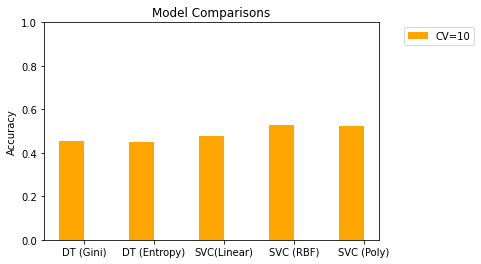

In [43]:
# Summarize the findings for all models

labels = ['DT (Gini)', 'DT (Entropy)', 'SVC(Linear)', 'SVC (RBF)', 'SVC (Poly)']
training_scores = [gini_dt_score, entropy_dt_score, linear_svc_clf_score, rbf_svc_clf_score, poly_svc_clf_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=10', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

|--- Ever_Married_N <= -0.57
|   |--- Ever_Married_N <= -1.16
|   |   |--- Profession_8 <= 0.50
|   |   |   |--- truncated branch of depth 18
|   |   |--- Profession_8 >  0.50
|   |   |   |--- truncated branch of depth 4
|   |--- Ever_Married_N >  -1.16
|   |   |--- Profession_3 <= 0.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Profession_3 >  0.50
|   |   |   |--- truncated branch of depth 14
|--- Ever_Married_N >  -0.57
|   |--- Family_Size <= 0.50
|   |   |--- Profession_3 <= 0.50
|   |   |   |--- truncated branch of depth 25
|   |   |--- Profession_3 >  0.50
|   |   |   |--- truncated branch of depth 23
|   |--- Family_Size >  0.50
|   |   |--- Profession_3 <= 0.50
|   |   |   |--- truncated branch of depth 23
|   |   |--- Profession_3 >  0.50
|   |   |   |--- truncated branch of depth 17



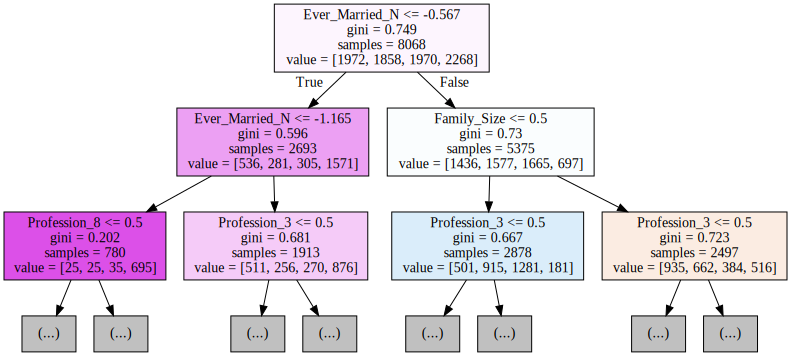

In [50]:
# Convert the decision tree model to text and graph

from matplotlib import pyplot
from sklearn.tree import export_text, export_graphviz
import graphviz

# we need to refit the DT model that is part of a composite pipe before exporting it as text
gini_dt_clf['classifier'].fit(preprocessor.fit_transform(X_train), y_train)


# display the induced decision tree as a series of logical rules
text_representation = export_text(gini_dt_clf['classifier'],
                      feature_names=['Ever_Married_N', 'Ever_Married_Y', 'Graduated_N', 'Graduated_Y', 
                      'Profession_1', 'Profession_2', 'Profession_3', 'Profession_4', 'Profession_5', 'Profession_6', 'Profession_7', 'Profession_8', 'Profession_9', 
                      'Spending_Score_Avg', 'Spending_Score_High', 'Spending_Score_Low', 'Age', 'Family_Size'],
                      max_depth=2)
print(text_representation)


# draw the induced decision tree
dot_data = export_graphviz(gini_dt_clf['classifier'],
                      max_depth=2,
                      feature_names=['Ever_Married_N', 'Ever_Married_Y', 'Graduated_N', 'Graduated_Y', 
                      'Profession_1', 'Profession_2', 'Profession_3', 'Profession_4', 'Profession_5', 'Profession_6', 'Profession_7', 'Profession_8', 'Profession_9', 
                      'Spending_Score_Avg', 'Spending_Score_High', 'Spending_Score_Low', 'Age', 'Family_Size'],
                      filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

Feature: 0, Score: 0.48924
Feature: 1, Score: 0.17103
Feature: 2, Score: 0.02091
Feature: 3, Score: 0.02135
Feature: 4, Score: 0.02055
Feature: 5, Score: 0.01653
Feature: 6, Score: 0.05570
Feature: 7, Score: 0.01644
Feature: 8, Score: 0.01629
Feature: 9, Score: 0.01737
Feature: 10, Score: 0.01219
Feature: 11, Score: 0.02123
Feature: 12, Score: 0.01382
Feature: 13, Score: 0.00692
Feature: 14, Score: 0.01517
Feature: 15, Score: 0.01738
Feature: 16, Score: 0.01110
Feature: 17, Score: 0.05678


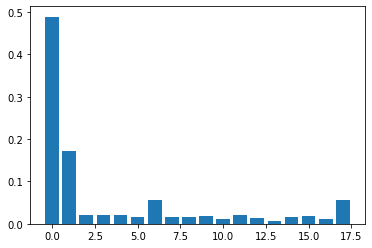

In [51]:
# get feature importances from the model
importance = gini_dt_clf['classifier'].feature_importances_

# summarize feature importances
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importances
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


In [52]:
# Use GridSearchCV to find optimum hyperparameter values for the DT model


# create a dictionary of all values we want to test
param_grid1 = { 'criterion':['entropy'],    # impurity criterion
              'max_depth': np.arange(3, 10)}      # tree depth 
   
    
# use gridsearch to test all values
grid_search1 = GridSearchCV(entropy_dt_clf['classifier'], 
                           param_grid1, 
                           cv=3)
    
# fit the model 
grid_search1.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search1.best_score_))

print("The best DT model hyperparameters:", grid_search1.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.52 

The best DT model hyperparameters: {'criterion': 'gini', 'max_depth': 6}


In [53]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC poly model


# create a dictionary of all values we want to test
param_grid2 = {'kernel':['poly'], 
              'gamma':['scale','auto'],      # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter
   
    
# use gridsearch to test all values
grid_search2 = GridSearchCV(poly_svc_clf['classifier'], 
                           param_grid2, 
                           cv=3)
    
# fit the model 
grid_search2.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search2.best_score_)

print("The best SVC poly model hyperparameters:", grid_search2.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.52

The best SVC poly model hyperparameters: {'C': 8, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}


In [55]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC rbf model


# create a dictionary of all values we want to test
param_grid3 = {'kernel':['rbf'], 
              'gamma':['scale','auto'],      # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter
   
    
# use gridsearch to test all values
grid_search3 = GridSearchCV(rbf_svc_clf['classifier'], 
                           param_grid3, 
                           cv=3)
    
# fit the model 
grid_search3.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search3.best_score_)

print("The best SVC RBF model hyperparameters:", grid_search3.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.52

The best SVC RBF model hyperparameters: {'C': 3, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}


In [57]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC Linear model


# create a dictionary of all values we want to test
param_grid4 = {'kernel':['linear'], 
              'gamma':['scale','auto'],      # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              'degree': np.arange(4,8),      # polynomial degree
              'C': np.arange(1,10)}          # Regularization parameter
   
    
# use gridsearch to test all values
grid_search4 = GridSearchCV(linear_svc_clf['classifier'], 
                           param_grid4, 
                           cv=3)
    
# fit the model 
grid_search4.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search4.best_score_)

print("The best SVC Linear model hyperparameters:", grid_search4.best_params_)

The best achieved accuracy after hyperparameter optimization: 0.48

The best SVC Linear model hyperparameters: {'C': 2, 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}


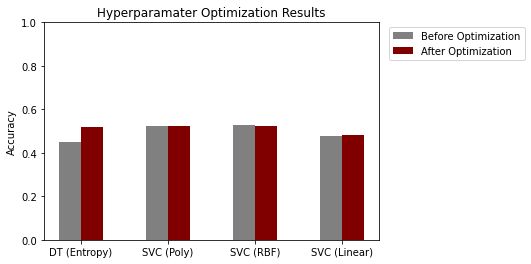

In [58]:
# graph results of grid search for the two models

labels = ['DT (Entropy)', 'SVC (Poly)', 'SVC (RBF)', 'SVC (Linear)']
before_optimization_scores = [entropy_dt_score, poly_svc_clf_score, rbf_svc_clf_score, linear_svc_clf_score]
after_optimization_scores = [grid_search1.best_score_, grid_search2.best_score_, grid_search3.best_score_, grid_search4.best_score_]

x = np.arange(len(labels))  # the label locations
width = 0.25                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_optimization_scores, width, label='Before Optimization', color='gray')
rects2 = ax.bar(x + width/2, after_optimization_scores, width, label='After Optimization', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1.0)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.45, 1.0), loc='upper right')

plt.title('Hyperparamater Optimization Results')
plt.show()
